In [1]:
import wandb
import numpy as np
import pandas as pd
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [85]:
#can use api to get run ids but have just donwloaded the flat cvs file instead. 
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("aaronwtr/perturbench")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

#runs_df.to_csv("project.csv")

In [133]:
df = pd.read_csv('wandb_baseline.csv')
df_scgpt = pd.read_csv('wandb_scgpt.csv')
df_gf = pd.read_csv('wandb_gf.csv')

In [75]:
df = pd.read_csv('wandb_baseline.csv')
df.head()

,Name,Created,Group,Tags,test/mse,test_baseline/mse,test_de/mse,train/mse,val/mse
0,stoic-haze-56,2024-06-05T14:17:35.000Z,test_mlp_norman_0.7,"IKZF3_de, eval, mlp, norman, replicate_1, spli...",NaN,0.190044,0.186191,NaN,NaN
1,youthful-hill-37,2024-06-05T02:28:56.000Z,test_mlp_norman_0.0,"SLC4A1_de, eval, mlp, norman, replicate_0, spl...",NaN,0.383467,0.370128,NaN,NaN
2,lemon-vortex-33,2024-06-05T02:13:27.000Z,test_mlp_norman_0.0,"SET_de, eval, mlp, norman, replicate_0, split_0.0",NaN,0.300423,0.296696,NaN,NaN
3,prime-disco-230,2024-06-04T01:09:47.000Z,mlp_norman_0.8,"mlp, norman, replicate_1, split_0.8",0.071544,NaN,NaN,0.060080,0.057698
4,eternal-sun-229,2024-06-04T01:09:13.000Z,mlp_norman_0.8,"mlp, norman, replicate_0, split_0.8",0.063389,NaN,NaN,0.075439,0.076257


plt.style.use("seaborn")

## MSE plots for spectral params

In [212]:
spectral_params = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7'] #'0.8']
def find_mets_by_spectral_params(model, metric_name, raw_data):
    '''find tabular metrics grouped by the spectral params'''
    met_by_sp = {}
    for sp in spectral_params:
        sp_sub = raw_data[raw_data['Group'] == f'{model}_{sp}']
        met_by_sp[f'{model}_{sp}'] = sp_sub[metric_name].values
    return pd.DataFrame(met_by_sp)

def find_spectral_auc(metric_df):
    x = np.array(spectral_params, dtype='float')
    y = metric_df.mean()
    return auc(x, y)

def plot_spectral_curve(metric_df, err='standard_error', zero_ylb=False, shading=True, errbar=True, c="#D1E7FF", alpha=0.8,
                        plot_shading_c_same=True):
    x = np.array(spectral_params, dtype='float')
    y = metric_df.mean()
    if err == 'standard_error':
        yerr = metric_df.std() / (len(metric_df) ** 0.5 ) #Standard error for err bar 
    
    if errbar: #safe to remove if we go with fill_between for errors
        plt.errorbar(x, y, yerr=yerr, color='k', capsize = 3,elinewidth=1.5, linewidth=1.0)    
    else:
        if plot_shading_c_same:
            plot_c = c
        else:
            plot_c = 'k'
        plt.plot(x, y, color=plot_c, linestyle='dashed', marker='o', linewidth=0.5)
        y_lower = y - yerr
        y_upper = y + yerr
        plt.fill_between(x, y_lower, y_upper, color=c, alpha=alpha, 
        #edgecolor='#aad3ff'
        )
    axes = plt.gca()
    y_min, _ = axes.get_ylim()
    #
    if zero_ylb:
        y_min = 0
    if shading:
        plt.fill_between(x=x, y1=y, y2=y_min, color= "#D1E7FF", alpha=1.0)
    plt.xlabel('Spectral Parameter')
    plt.ylabel('MSE')


def find_ausc_table(all_model_raw_dfs, model_names, probe_model_ds='mlp_norman', metric_name='test/mse'):
    '''probe_model_ds named in Group col in df above 
    metric_name  name of col for metric of intrest
    '''
    table = {}
    for m_name, dft in zip(model_names, all_model_raw_dfs):
        auc = find_spectral_auc(find_mets_by_spectral_params(probe_model_ds, metric_name, dft))
        table[m_name] = auc
    return table

In [191]:
probe_model_ds = 'mlp_norman' #as named in Group col in df above
metric_name  = 'test/mse' #name of col for metric of intrest
test_mse = find_mets_by_spectral_params(probe_model_ds, metric_name, df)
test_mse_scgpt = find_mets_by_spectral_params(probe_model_ds, metric_name, df_scgpt)
test_mse_gf = find_mets_by_spectral_params(probe_model_ds, metric_name, df_gf)

find_spectral_auc(test_mse), find_spectral_auc(test_mse_gf), find_spectral_auc(test_mse_scgpt)

(0.04582182324180996, 0.06140315545101957, 0.07250125538557764)

In [426]:
table = find_ausc_table([df, df_scgpt, df_gf], model_names=['Baseline', 'scgt', 'gf'])
table = pd.Series(table).sort_values()

In [427]:
table

Baseline    0.045822
gf          0.061403
scgt        0.072501
dtype: float64

### Box plot for aucpr

C:\Users\Nik\AppData\Local\Temp\ipykernel_24980\822303489.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(table))


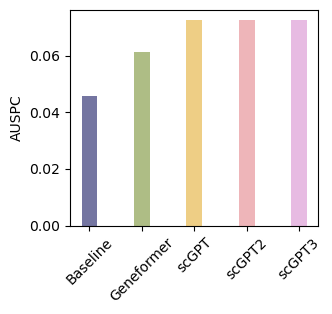

In [450]:
plt.figure(figsize=(3.2, 2.8))
table = find_ausc_table([df, df_scgpt, df_gf, df_scgpt, df_scgpt], model_names=['Baseline', 'scGPT', 'Geneformer', 'scGPT2', 'scGPT3'])
table = pd.Series(table).sort_values()

cmap = plt.cm.get_cmap('tab20b', len(table)) 
bar_colors = [cmap(i) for i in range(len(table))]
width = 0.3
plt.bar(table.index, table, width, color=bar_colors, alpha=0.7)
#plt.xlabel('Model')
plt.ylabel('AUSPC')
plt.xticks(rotation=45)

plt.show()

In [ ]:
def de_boxplot(de_results_dict, pert, models_name_mapping):
    y = de_results_dict[pert]
    assert len(y) == 1 #no reps 
    y = y.iloc[0].sort_values(ascending=True)
    cmap = plt.cm.get_cmap('tab20b', len(y)) 
    bar_colors = [cmap(i) for i in range(len(y))]
    bar_labels = [models_name_mapping[l] for l in y.index]
    plt.bar(bar_labels, y, label=bar_labels, 
            color=bar_colors, alpha=0.9
            )
    plt.xlabel(f'Perturbation {pert}')
    plt.ylabel('MSE')
    #plt.show()

In [149]:
((test_mse - test_mse_scgpt) > 0).sum().sum() #scgpt only beats baseline for 2 splits

2

In [150]:
((test_mse - test_mse_gf) > 0).sum().sum()  #gf beats baseline for 6 splits

6

In [140]:
find_spectral_auc(test_mse_gf[test_mse_gf < 0.1]), find_spectral_auc(test_mse_scgpt[test_mse_scgpt < 0.1])

(0.04823722081879772, 0.051043300889432396)

#### auc table and plots

In [ ]:
find_ausc_table()

In [126]:
plt.style.use('default')

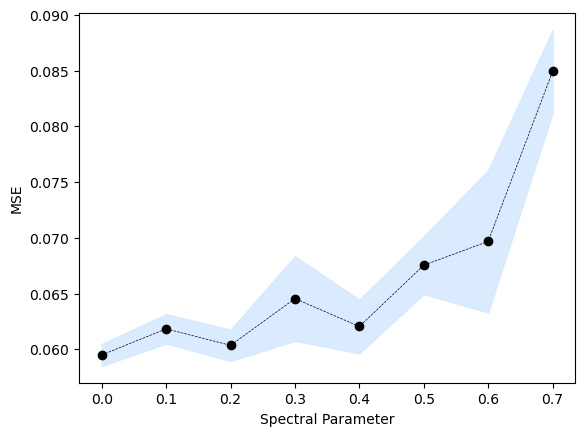

In [382]:
#current plot that we think well use
plot_spectral_curve(test_mse, shading=False, errbar=False, plot_shading_c_same=False)

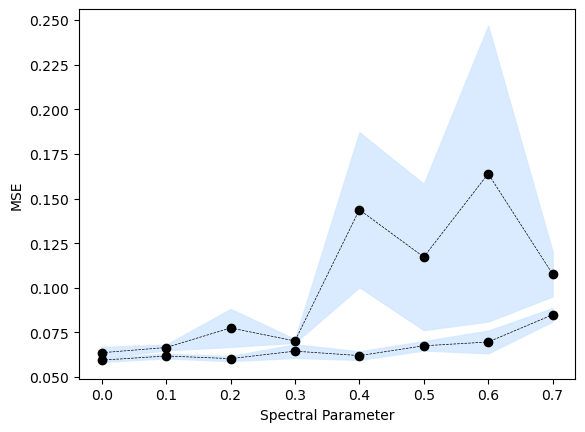

In [214]:
plot_spectral_curve(test_mse_scgpt, shading=False, errbar=False, plot_shading_c_same=False)
plot_spectral_curve(test_mse, shading=False, errbar=False, plot_shading_c_same=False)

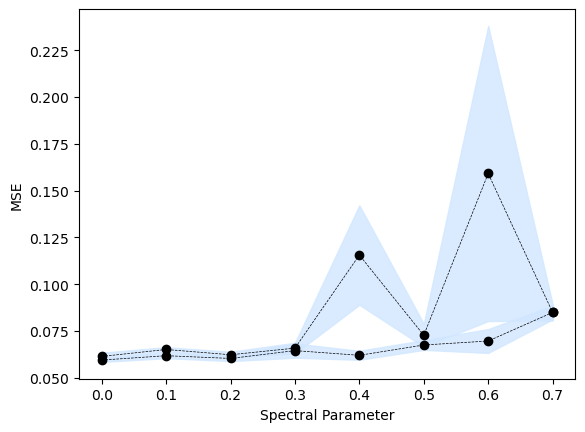

In [215]:
plot_spectral_curve(test_mse_gf, shading=False, errbar=False, plot_shading_c_same=False)
plot_spectral_curve(test_mse, shading=False, errbar=False, plot_shading_c_same=False)

In [293]:
test_mse_scgpt

,mlp_norman_0.0,mlp_norman_0.1,mlp_norman_0.2,mlp_norman_0.3,mlp_norman_0.4,mlp_norman_0.5,mlp_norman_0.6,mlp_norman_0.7
0,0.059957,0.066024,0.065731,0.072156,0.063538,0.197646,0.329465,0.084888
1,0.060969,0.069510,0.098719,0.069975,0.155105,0.090425,0.082842,0.110261
2,0.070075,0.064205,0.068142,0.068667,0.212596,0.063749,0.079468,0.128001


C:\Users\Nik\AppData\Local\Temp\ipykernel_24980\3947037676.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', n_models)


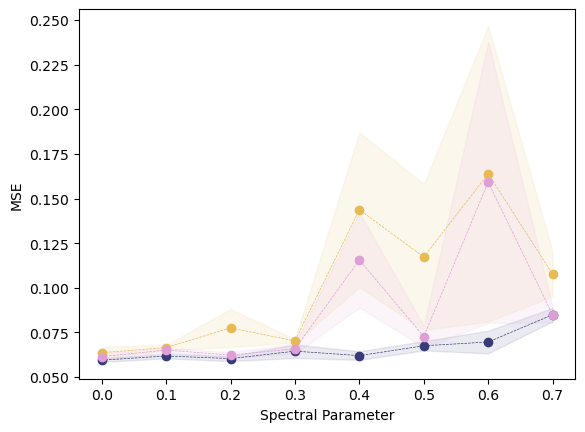

In [299]:
n_models = 3
cmap = plt.cm.get_cmap('tab20b', n_models) 
alpha = 1
plot_spectral_curve(test_mse, shading=False, errbar=False, c=bar_colors[0], alpha=alpha* 0.1)
plot_spectral_curve(test_mse_scgpt, shading=False, errbar=False, c=bar_colors[1], alpha=alpha * 0.1)
#plot_spectral_curve(test_mse_scgpt, shading=False, errbar=False, c=bar_colors[1], alpha=alpha * 0.1)
plot_spectral_curve(test_mse_gf, shading=False, errbar=False, c=bar_colors[2], alpha=alpha * 0.1)
#plt.yscale('log',  base=2)

C:\Users\Nik\AppData\Local\Temp\ipykernel_24980\3969312826.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', n_models)


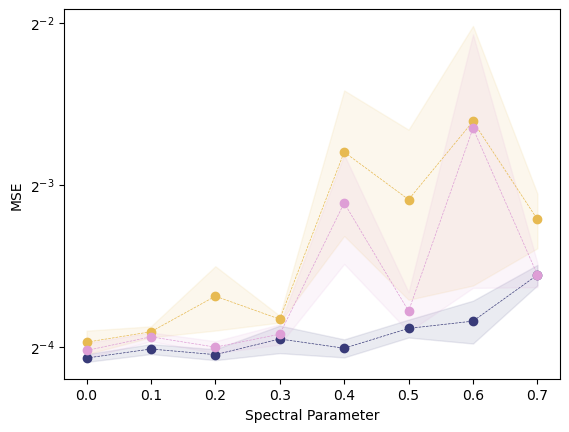

In [288]:
n_models = 3
cmap = plt.cm.get_cmap('tab20b', n_models) 
bar_colors = [cmap(i) for i in range(n_models)]
alpha = 1
plot_spectral_curve(test_mse, shading=False, errbar=False, c=bar_colors[0], alpha=alpha* 0.1)
plot_spectral_curve(test_mse_scgpt, shading=False, errbar=False, c=bar_colors[1], alpha=alpha * 0.1)
#plot_spectral_curve(test_mse_scgpt, shading=False, errbar=False, c=bar_colors[1], alpha=alpha * 0.1)
plot_spectral_curve(test_mse_gf, shading=False, errbar=False, c=bar_colors[2], alpha=alpha * 0.1)
#plt.yscale('log',  base=2)

### scatter plot too messey try bar plot with err bars

In [416]:
model_names=['Baseline', 'Geneformer', 'scGPT']
model_mses=[test_mse, test_mse_gf, test_mse_scgpt]


C:\Users\Nik\AppData\Local\Temp\ipykernel_24980\110204462.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(model_names))


(0.05, 0.165)

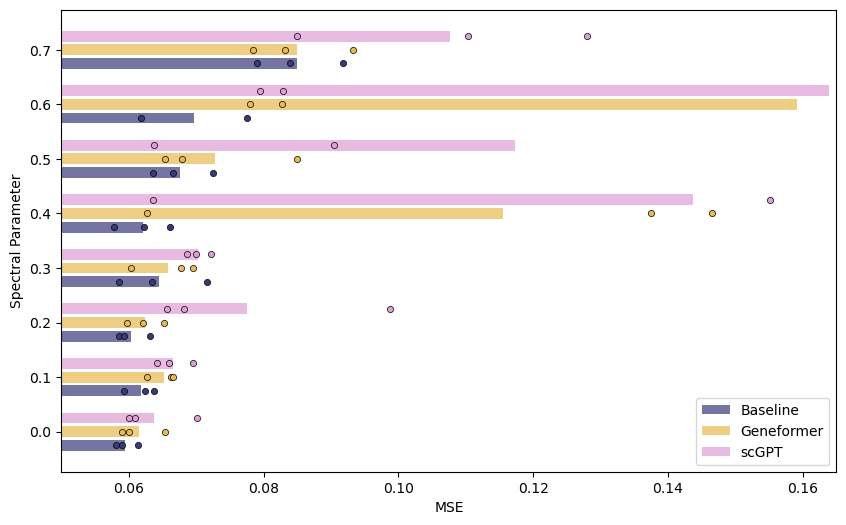

In [417]:
model_names=['Baseline', 'Geneformer', 'scGPT']
model_mses=[test_mse, test_mse_gf, test_mse_scgpt]


spectral_params = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7'] 
x_labels = spectral_params
bars = []
dists_from_cent = np.arange(-len(model_names)/2 + 1, len(model_names)/2 - 0.5, 0.5) #needs to be equal to the number of modles with equal spacing
plt.figure(figsize=(10,6))
#dists_from_cent = [-0.5, 0, 0.5]
#e.g. [-1.5, -0.5, 0.5, 1.5] for 4 modles
assert len(dist_from_cent) == len(model_names)
pivot = np.arange(len(x_labels)) # pivot points for bars/ticks

cmap = plt.cm.get_cmap('tab20b', len(model_names)) 
bar_colors = [cmap(i) for i in range(len(model_names))]

width = 0.2 
for model, m_mse, dis_from_cent, c in zip(model_names, model_mses, dists_from_cent, bar_colors):
    y = m_mse.mean()
    bar = [p + (dis_from_cent * width * 2.5) for p in pivot]
    bars.append(bar)
    plt.barh(bar, y, width, alpha=0.7,
    label=model,
    color=c
    #yerr=m_mse.std()
    )
    for rep in m_mse.iterrows():
        plt.scatter(rep[1], bar, color=c, edgecolors='black', linewidths=0.5, s=20)

plt.yticks(np.arange(8), spectral_params) #rotation='vertical')
plt.xlabel('MSE')
plt.ylabel('Spectral Parameter')
plt.legend(loc='lower right')
#plt.xlim(0.05, 0.17)
plt.xlim(0.05, 0.165)
#plt.show()
#plt.yscale('log',  base=2)
#plt.bar(baseline_ba)

In [ ]:
def ausc_boxplot():
    y = de_results_dict[pert]
    assert len(y) == 1 #no reps 
    y = y.iloc[0].sort_values(ascending=True)
    cmap = plt.cm.get_cmap('tab20b', len(y)) 
    bar_colors = [cmap(i) for i in range(len(y))]
    bar_labels = [models_name_mapping[l] for l in y.index]
    plt.bar(bar_labels, y, label=bar_labels, 
            color=bar_colors, alpha=0.9
            )
    plt.xlabel(f'Perturbation {pert}')
    plt.ylabel('MSE')
    #plt.show()

## Plots and table for differentally expressed genes 

In [98]:
#diff expressed gene results have _de in there tags find idx of de gene
def find_diff_expres_subset(raw_results_df):
    diff_expres_idx = []
    diff_expres_genes = []
    for i, t in enumerate(raw_results_df['Tags']):
        if '_de' in t.split(',')[0]:
            diff_expres_idx.append(i)
            diff_expres_genes.append(t.split('_')[0])

    de_df = raw_results_df.iloc[diff_expres_idx].copy(deep=True)
    de_df['diff_express_gene'] = diff_expres_genes
    #drop missing (old perts we considered)
    de_df = de_df[~de_df['test_baseline/mse'].isna()]

    return diff_expres_idx, diff_expres_genes, de_df

def find_de_mets_by_gene(diff_express_df, sp, model, metrics=['test_baseline/mse', 'test_de/mse']):
    '''find tabular metrics grouped by de gene for a given (sp) spectral param'''
    results = {}
    sp_subset = diff_express_df[diff_express_df['Group'] == f'test_{model}_{sp}']
    for g in sp_subset['diff_express_gene']:
        de_df_subset = sp_subset[sp_subset['diff_express_gene'] == g]
        results[g] = de_df_subset[metrics]
    return results

def create_de_table(de_results_dict, models_name_mapping):
    #tabular results 
    de_tab = pd.concat(de_results_dict)
    if isinstance(de_tab, pd.Series):
        de_tab = pd.DataFrame(de_tab)
    #fmt table
    cols = [models_name_mapping[l] for l in de_tab.columns]
    de_tab.columns = cols
    new_idx = [idx[0] for idx in de_tab.index]
    de_tab.index = new_idx
    de_tab = de_tab.T.sort_values(by=new_idx[0])
    return de_tab

In [85]:
#subset raw results to just differenctal expression results 
diff_expres_idx, diff_expres_genes, de_df = find_diff_expres_subset(df)
#*_, de_df_r2 = find_diff_expres_subset(df2)

### table of de results

In [64]:
de_sp0_r2 = find_de_mets_by_gene(de_df_r2, sp, probe_model_ds)

In [66]:
de_sp0_r2

{'SLC4A1':    test_baseline/mse  test_de/mse
 0           0.383467     0.370128,
 'SET':    test_baseline/mse  test_de/mse
 1           0.300423     0.296696}

In [65]:
de_sp0

{'SLC4A1':    test_baseline/mse  test_de/mse
 0           0.383467     0.370128,
 'SET':    test_baseline/mse  test_de/mse
 1           0.300423     0.296696}

In [99]:
#sp and probe_model_ds should be the same for all de_sp dfs created
sp = 0.0
probe_model_ds = 'mlp_norman'

#name will change depending on fm model used 
models_name_mapping = {'test_baseline/mse': 'Null Benchmark', 'test_de/mse' : 'MLP Baseline'} 

de_sp0 = find_de_mets_by_gene(de_df, sp, probe_model_ds)
de_sp0_tab = create_de_table(de_sp0, models_name_mapping)

models_name_mapping = {'test_de/mse' : 'MLP Baseline_r2'} 
de_sp0_r2 = find_de_mets_by_gene(de_df, sp, probe_model_ds,  metrics='test_de/mse')
de_sp0_r2_tab = create_de_table(de_sp0_r2, models_name_mapping)
de_sp0_r2_tab

,SLC4A1,SET
MLP Baseline_r2,0.370128,0.296696


In [100]:
pd.concat((de_sp0_tab, de_sp0_r2_tab))

,SLC4A1,SET
MLP Baseline,0.370128,0.296696
Null Benchmark,0.383467,0.300423
MLP Baseline_r2,0.370128,0.296696


In [86]:
sp = 0.7
probe_model_ds = 'mlp_norman'
models_name_mapping = {'test_baseline/mse': 'Null Benchmark', 'test_de/mse' : 'MLP Baseline'} #form de_df above
de_sp7 = find_de_mets_by_gene(de_df, sp, probe_model_ds)
de_sp7_tab = create_de_table(de_sp7, models_name_mapping)
#de_sp0_r2_tab = create_de_table(de_sp0_r2, models_name_mapping)
de_sp7_tab

,IKZF3
MLP Baseline,0.186191
Null Benchmark,0.190044


### box plots of de results

In [103]:
def de_boxplot(de_results_dict, pert, models_name_mapping):
    y = de_results_dict[pert]
    assert len(y) == 1 #no reps 
    y = y.iloc[0].sort_values(ascending=True)
    cmap = plt.cm.get_cmap('tab20b', len(y)) 
    bar_colors = [cmap(i) for i in range(len(y))]
    bar_labels = [models_name_mapping[l] for l in y.index]
    plt.bar(bar_labels, y, label=bar_labels, 
            color=bar_colors, alpha=0.9
            )
    plt.xlabel(f'Perturbation {pert}')
    plt.ylabel('MSE')
    #plt.show()

In [218]:
models_name_mapping

{'test_de/mse': 'MLP Baseline_r2'}

In [217]:
de_sp0[pert]

,test_baseline/mse,test_de/mse
1,0.383467,0.370128


C:\Users\Nik\AppData\Local\Temp\ipykernel_24980\170521812.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(y))


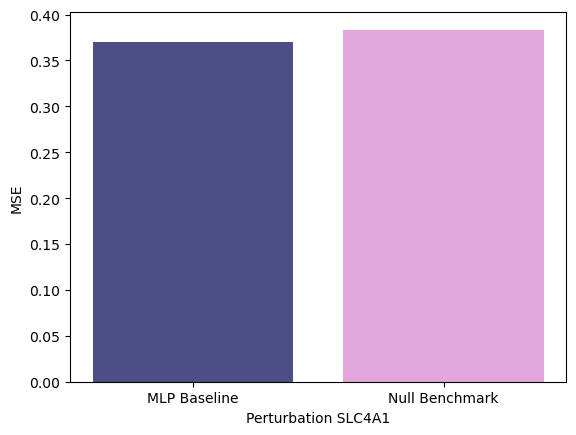

In [219]:
#just using SLC4A1 pert for sp of zero
pert = 'SLC4A1'
models_name_mapping = {'test_baseline/mse': 'Null Benchmark', 'test_de/mse' : 'MLP Baseline'} 
de_boxplot(de_sp0, pert, models_name_mapping)
plt.show()

In [109]:
models_name_mapping

{'test_de/mse': 'MLP Baseline_r2'}

In [108]:
de_sp0[pert]['test_baseline/mse']

1    0.383467
Name: test_baseline/mse, dtype: float64